In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plot
from datetime import timedelta
sns.set_style('darkgrid')

In [81]:
# Data Cleaning
data = pd.read_csv('../Stocks_daily/BA.csv', index_col=0)
data.index = pd.to_datetime( data.index, format='%Y-%m-%d' )
data.sort_index( inplace=True, ascending=True )
data['Close'] = data['Adjusted Close']
data['Close.next'] = data['Close'].shift(-1) 
data['Buy'] = np.where( data['Close.next'] > data['Close'], 1, 0 )
sentiment_data = pd.read_csv('../MarketSentiment/csvData/BA/BA.csv', index_col=0)
sentiment_data.index = pd.to_datetime( sentiment_data.index, format='%Y-%m-%d' )
data['Sentiment'] = sentiment_data['Total Sentiment']
data['Number of Articles'] = sentiment_data['Number of Articles']
fundamentals_data = pd.read_csv('../Fundamentals/csvData/BA.csv', index_col=0)
fundamentals_data.index = pd.to_datetime( fundamentals_data.index, format='%Y-%m-%d' )
fundamentals_data = fundamentals_data.resample('D').ffill()
data['Earnings'] = fundamentals_data['eps_diluted']
data['Book Value'] = fundamentals_data['bvps_diluted']
tenyear_ir_data = pd.read_csv('../Economic_Indicators/TREASURY_YIELD&maturity=10year.csv', index_col=0)
tenyear_ir_data.index = pd.to_datetime( tenyear_ir_data.index, format='%Y-%m-%d' )
tenyear_ir_data = tenyear_ir_data.resample('D').ffill()
tenyear_ir_data.sort_index( inplace=True, ascending=True )
inflation_data = pd.read_csv('../Economic_Indicators/INFLATION.csv', index_col=0)
inflation_data.index = pd.to_datetime( inflation_data.index, format='%Y-%m-%d' )
inflation_data.sort_index( inplace=True, ascending=True )
inflation_data = inflation_data.resample('D').ffill()
data['dt'] = data.index.to_series().diff() / timedelta(days=1)
data['10y'] = tenyear_ir_data['Values'].replace()
data['10y.diff'] = data['10y'].pct_change()
data['Inflation'] = inflation_data['Values']
print( data['Inflation'] )
data = data.dropna()
input_vars = ['Open', 'High', 'Low', 'Close', 'Volume', 'Sentiment', 'Number of Articles', 'Earnings', 'Book Value', 'dt', '10y', '10y.diff', 'Inflation']
output_var = 'Close.next'

1999-11-01    2.188027
1999-11-02    2.188027
1999-11-03    2.188027
1999-11-04    2.188027
1999-11-05    2.188027
                ...   
2023-07-12         NaN
2023-07-13         NaN
2023-07-14         NaN
2023-07-17         NaN
2023-07-18         NaN
Name: Inflation, Length: 5965, dtype: float64


In [82]:
print(data)

              Open      High     Low       Close  Adjusted Close    Volume  \
2009-07-22   42.40   43.4600   41.95   32.089996       32.089996  12052300   
2009-07-23   42.00   42.1900   40.78   32.051794       32.051794  13617700   
2009-07-24   41.95   42.4900   41.72   32.372694       32.372694   5068000   
2009-07-27   42.00   42.3700   41.43   32.273367       32.273367   5671700   
2009-07-28   41.99   43.3500   41.80   33.045055       33.045055   7831200   
...            ...       ...     ...         ...             ...       ...   
2021-12-27  201.99  203.4300  199.10  203.170000      203.170000   7826624   
2021-12-28  202.23  208.9373  201.65  206.130000      206.130000   8885989   
2021-12-29  205.36  205.4100  202.60  203.660000      203.660000   6119004   
2021-12-30  203.00  206.0000  202.60  202.710000      202.710000   7012644   
2021-12-31  202.20  203.6900  200.03  201.320000      201.320000   8016593   

            Dividend Amount  Split Coefficient  Close.next  Buy

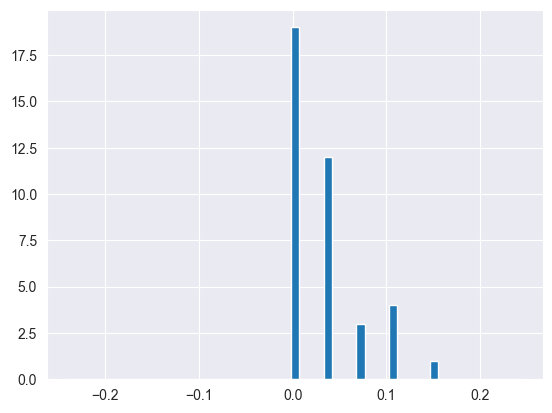

[ 0.03701329  0.          0.          0.          0.          0.
  0.11103988  0.          0.03701329  0.          0.          0.03701329
  0.          0.03701329  0.          0.03701329  0.          0.03701329
  0.11103988  0.25909305  0.51818609  0.81429243  1.59157158  2.51690389
  5.14484765 12.32542639 24.65085279 28.94439472 19.72808489  8.10591105
  4.18250205  2.25781084  0.74026585  0.77727914  0.37013292  0.14805317
  0.11103988  0.          0.07402658  0.03701329  0.07402658  0.07402658
  0.11103988  0.03701329  0.03701329  0.          0.          0.
  0.          0.03701329  0.          0.03701329  0.          0.
  0.03701329]
[-0.23848414 -0.2297265  -0.22096886 -0.21221121 -0.20345357 -0.19469593
 -0.18593829 -0.17718065 -0.16842301 -0.15966537 -0.15090773 -0.14215009
 -0.13339245 -0.12463481 -0.11587717 -0.10711953 -0.09836189 -0.08960425
 -0.08084661 -0.07208897 -0.06333133 -0.05457369 -0.04581605 -0.03705841
 -0.02830076 -0.01954312 -0.01078548 -0.00202784  0.0067298  

In [83]:
plot.figure()
counts, bins = np.histogram( data['Close.next'] / data['Close'] - 1., bins=int(np.sqrt(data.shape[0])), density=True )
plot.hist( counts, bins=bins )
plot.show()
print(counts)
print(bins)

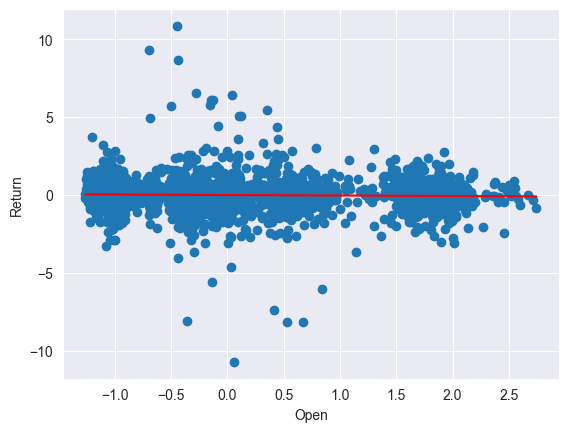

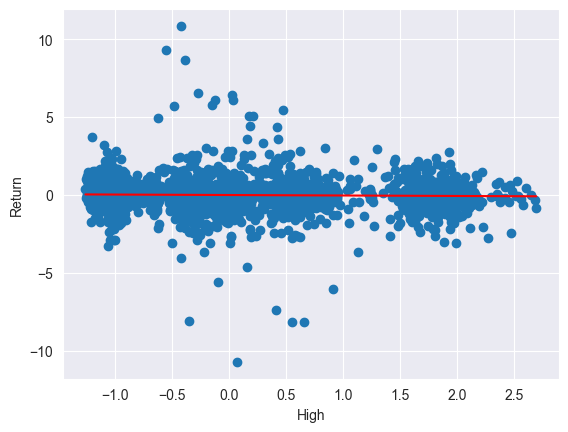

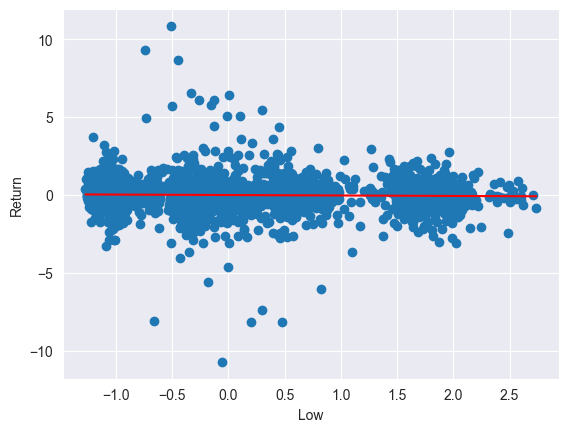

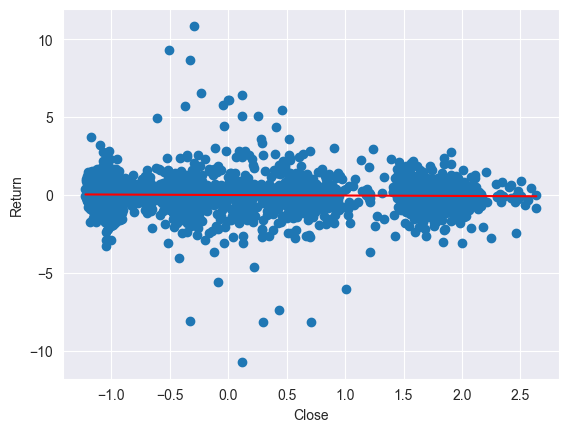

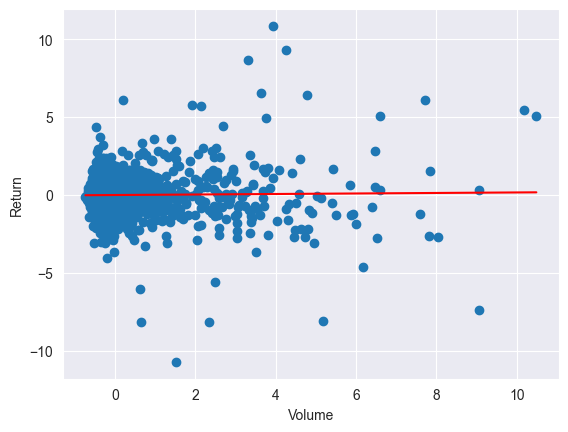

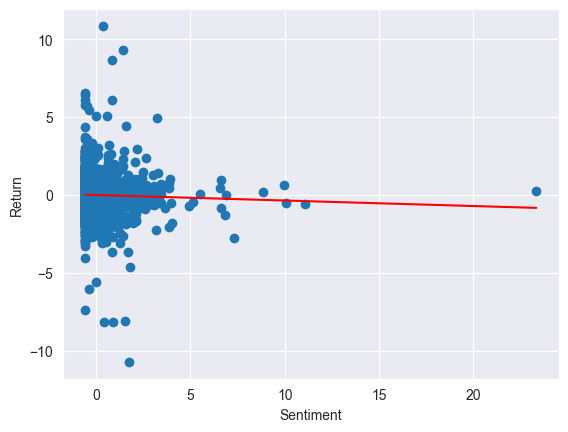

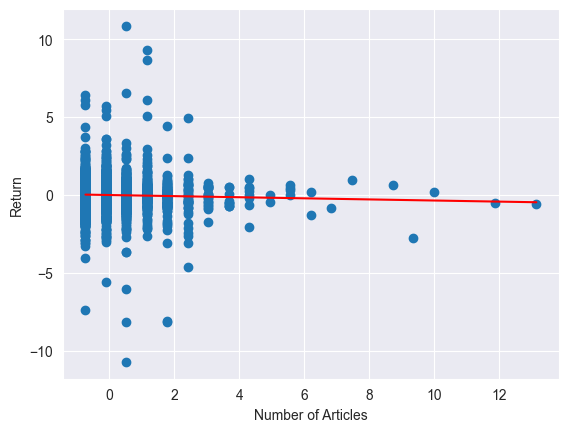

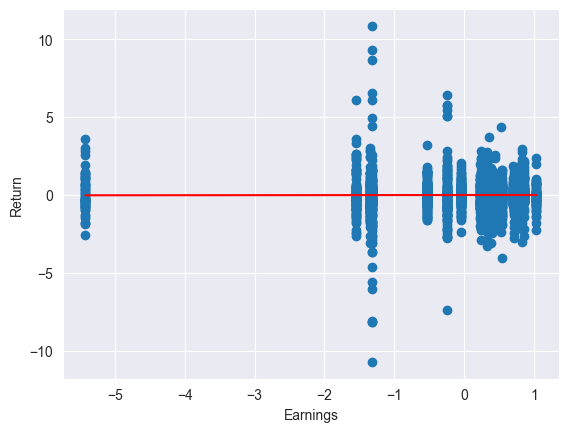

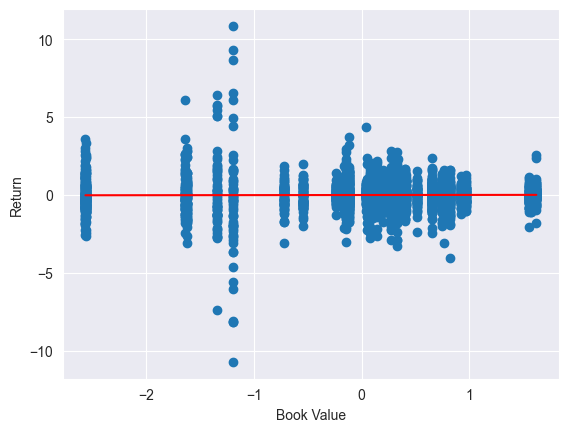

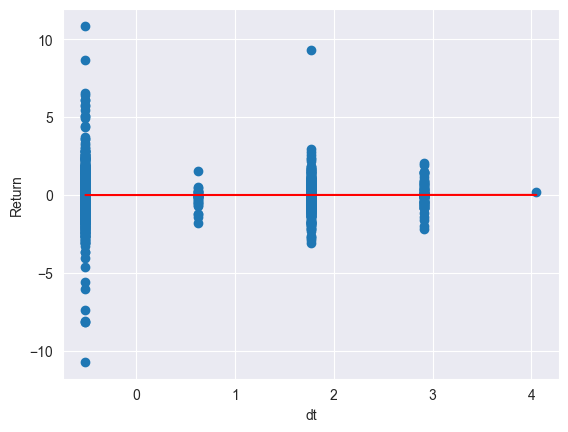

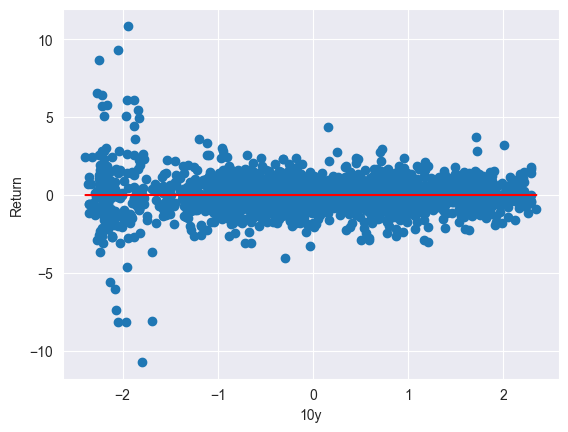

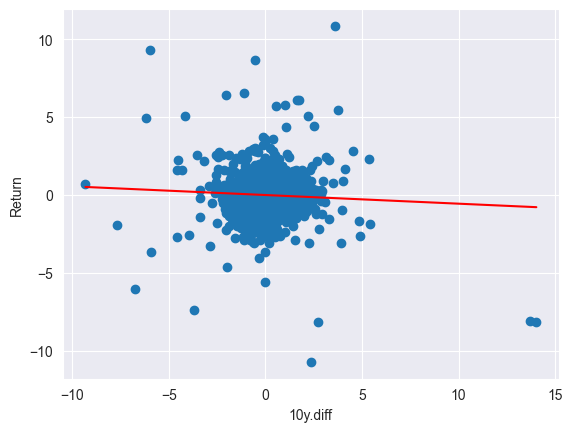

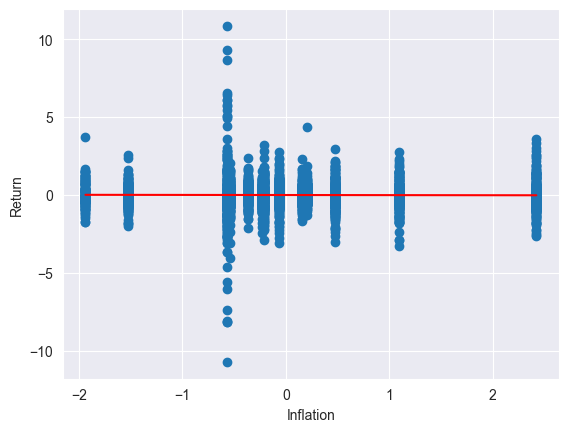

In [84]:
from sklearn.linear_model import LinearRegression
y = data['Close.next'] / data['Close'] - 1.
y = ( y - y.mean() ) / y.std()
for v in input_vars:
    model = LinearRegression( fit_intercept=True )
    data[v] = (data[v] - data[v].mean()) / data[v].std()
    model.fit( data[v].to_numpy().reshape(-1,1), y )
    t = np.linspace( data[v].min(), data[v].max(), num=100 )
    y_hat = model.coef_[0] * t + model.intercept_
    plot.figure()
    plot.scatter( data[v], y )
    plot.plot( t, y_hat, 'r-' )
    plot.xlabel(v)
    plot.ylabel('Return')
    plot.show()

In [92]:
from sklearn.feature_selection import mutual_info_classif
X = data[ input_vars ]
mi = mutual_info_classif( X, data['Buy'], n_neighbors=200 )
for idx, v in enumerate(input_vars):
    print( v, mi[idx] )

Open 0.0035855462536851235
High 0.004141403439829716
Low 0.0032929984199947526
Close 0.0031721733844012334
Volume 0.0007166105174807313
Sentiment 0.0
Number of Articles 0.0035279053699213136
Earnings 0.0
Book Value 0.0
dt 0.0
10y 0.0019219675098911537
10y.diff 0.0
Inflation 0.0
